In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

In [2]:
def get_data():
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    
    X = np.array([experiment - np.max(experiment) for experiment in X])
    X = np.array([experiment/-np.min(experiment) for experiment in X])

    y = np.round(y)
    y = y.astype(int)
    
    ## Let's shift each signal so that reference time matches for each signal
    mean_ref_time = int(y.mean())
    X = np.array([signal_cyclic_shift(signal, mean_ref_time - y[i]) for i, signal in enumerate(X, 0)])

    return X, y

def get_freq_data(X, freq=1, start_point=384):
    X_freq = np.concatenate([X[:, start_point::-freq][:, ::-1], X[:, start_point + freq::freq]], axis=1)
    return X_freq

def signal_cyclic_shift(signal, tau):
    signal_start = signal[:-tau]
    
    new_signal = np.concatenate([signal[-tau:], signal_start])
    
    return new_signal

In [3]:
X_origin, y_origin = get_data()

mean_argmin =  int(np.argmin(X_origin, axis=1).mean())

In [4]:
import random

def generate_multi_signal(X_origin, tau, alpha, to_plot=False):
    first_idx, second_idx = np.random.choice(X_origin.shape[0], 2, replace=False)
    first_impulse = X_origin[first_idx]
    second_impulse = X_origin[second_idx]
    
    
#     ### Randomly choose what signal to shift
#     if random.choice([True, False]):
#         first_impulse = signal_cyclic_shift(first_impulse, tau)
#     else:
#         second_impulse = signal_cyclic_shift(second_impulse, tau)
    
    second_impulse = signal_cyclic_shift(second_impulse, tau)

    multi_impulse = first_impulse + second_impulse*alpha
    multi_impulse /= -np.min(multi_impulse)
    
    first_impulse_shifted = signal_cyclic_shift(first_impulse, mean_argmin - np.argmin(first_impulse))
    second_impulse_shifted = signal_cyclic_shift(second_impulse, mean_argmin - np.argmin(second_impulse))
    multi_impulse_shifted = signal_cyclic_shift(multi_impulse, mean_argmin - np.argmin(multi_impulse))

    if to_plot:
        plt.plot(first_impulse)
        plt.plot(second_impulse)
        plt.plot(multi_impulse_shifted)
        plt.legend(['First signal', 'Second signal', 'Sum of signals'])
        plt.show()
        
    return {'first': first_impulse_shifted,\
            'second': second_impulse_shifted,\
            'multi': multi_impulse_shifted}

In [5]:
from sklearn.utils import shuffle

def prepare_data(X_origin, tau_range, alpha_range, data_size=1000, to_print=False):    
    X = []
    y = []
    alpha_values = []
    tau_values = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        signal = generate_multi_signal(X_origin, tau, alpha)['multi']
        
        X.append(signal)
        y.append(np.log10(alpha))
        
        alpha_values.append(alpha)
        tau_values.append(tau)
   
    X = np.array(X)
    y = np.array(y)
    
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

#     plt.scatter(alpha_values, tau_values)
#     plt.show()
    
    return X, y

In [6]:
# alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(0, 3.1, 0.01)])

alpha_range = np.array([10**i for i in np.arange(0, 3, 0.05)])
tau_range = np.arange(-100, 101, 1)

In [7]:
X, y = prepare_data(X_origin, tau_range, alpha_range, data_size=len(X_origin), to_print=True)
X = get_freq_data(X, freq=1)

X shape: (7848, 1024)
y shape: (7848,)


In [8]:
from sklearn.preprocessing import normalize

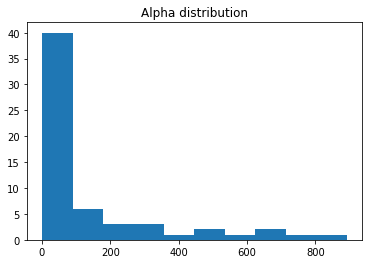

In [9]:
plt.title("Alpha distribution")
plt.hist(alpha_range)
plt.show()

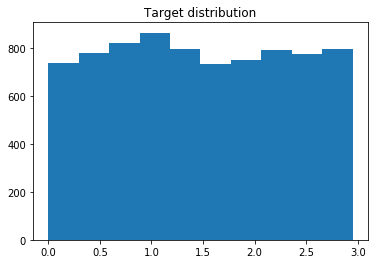

In [10]:
plt.title("Target distribution")
plt.hist(y)
plt.show()

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import PassiveAggressiveRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [12]:
def print_scores():
    for model in models:    
        model_name = type(model).__name__
        print("Regressor:", model_name)
    #         stregr = StackingRegressor(regressors=models, meta_regressor=model)
        scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
        scores = cross_validate(model, X, y, scoring=scoring, cv=5)

        r2_score_mean = scores['test_r2'].mean()
        r2_score_std = scores['test_r2'].std()
        mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
        mse_score_std = scores['test_neg_mean_squared_error'].std()
        mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
        mae_score_std = scores['test_neg_mean_absolute_error'].std()
        rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
        rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

        cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                          (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
        print("95% confidence interval:")
        for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
            print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
        print('----------------------------------')
    print('____________________________________________________________')
    print()

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
def get_models():
    huber_reg = HuberRegressor(epsilon= 4.927, alpha= 0.00759)
    ridge_reg = linear_model.Ridge(solver='saga', max_iter=5000, alpha= 1)
    lasso_reg = linear_model.Lasso(max_iter=5000, alpha=0.0001, normalize=False)
    dt_reg = tree.DecisionTreeRegressor(min_samples_split=9, min_samples_leaf=6, min_weight_fraction_leaf=0.03, 
                                                                                                 max_features='auto')

    pa_reg = PassiveAggressiveRegressor(C=0.00611, max_iter=2800, tol=5.719679731382862e-05)
    xgb_reg = xgb.XGBRegressor(objective="reg:linear", alpha= 0.01, booster='gbtree', eta= 0.323, gamma=0.189, 
                               reg_lambda=0.48, max_depth=6, verbosity=0)
    return [huber_reg, ridge_reg, lasso_reg, dt_reg,  pa_reg, xgb_reg]

In [15]:
models = get_models()

In [16]:
print_scores()

Regressor: HuberRegressor
95% confidence interval:
r2 score: 0.47426 (+/- 0.01705)
mse score: 0.39129 (+/- 0.02065)
mae score: 0.52412 (+/- 0.01280)
rmse score: 0.62548 (+/- 0.01640)
----------------------------------
Regressor: Ridge
95% confidence interval:
r2 score: 0.47927 (+/- 0.01887)
mse score: 0.38755 (+/- 0.02130)
mae score: 0.52035 (+/- 0.01291)
rmse score: 0.62248 (+/- 0.01701)
----------------------------------
Regressor: Lasso
95% confidence interval:
r2 score: 0.48606 (+/- 0.01896)
mse score: 0.38249 (+/- 0.02026)
mae score: 0.51723 (+/- 0.01217)
rmse score: 0.61841 (+/- 0.01633)
----------------------------------
Regressor: DecisionTreeRegressor
95% confidence interval:
r2 score: 0.65517 (+/- 0.05125)
mse score: 0.25637 (+/- 0.03123)
mae score: 0.34681 (+/- 0.01244)
rmse score: 0.50610 (+/- 0.03064)
----------------------------------
Regressor: PassiveAggressiveRegressor
95% confidence interval:
r2 score: 0.19725 (+/- 0.31256)
mse score: 0.59610 (+/- 0.22163)
mae score: 

### Stacking

In [17]:
from mlxtend.regressor import StackingRegressor


In [ ]:
for i in range(len(models)):
    models = get_models()
    print("Metaregressor:", type(models[i]).__name__)

    stregr = StackingRegressor(regressors=models, meta_regressor=models[i])
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(stregr, X, y, scoring=scoring, cv=5)

    r2_score_mean = scores['test_r2'].mean()
    r2_score_std = scores['test_r2'].std()
    mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
    mse_score_std = scores['test_neg_mean_squared_error'].std()
    mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
    mae_score_std = scores['test_neg_mean_absolute_error'].std()
    rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
    rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

    cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                      (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
    print("95% confindence interval:")
    for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
        print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
    print('--------------------------------------------------------')

### Let's plot scores for different sampling frequency values

In [17]:
alpha_values = np.array([np.around(10**i, decimals=4) for i in np.arange(0, 3.1, 0.1)])
tau_values = range(-25, 30, 5)
freq_values = [1, 25, 50, 60, 75, 85, 100]
# alpha_values = np.around(np.arange(0, 100, 2), decimals=2)

In [18]:
def calculate_scores(X_origin, alpha_values, tau_values, data_size=100, freq=1):
    scores_dict = {}
    
    X, y = prepare_data(X_origin, tau_values, alpha_values, to_print=False, data_size=len(X_origin))
    model = get_models()[-1]
    X_freq = get_freq_data(X, freq=freq)
    model.fit(X_freq, y)

    
    for tau in tqdm.tqdm(tau_values):
        scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))
        for alpha in alpha_values:
            X_cur, y_cur = prepare_data(X_origin, [tau], [alpha], data_size=data_size)
            X_cur = get_freq_data(X_cur, freq=freq)
            
            y_pred = model.predict(X_cur)
            scores_dict[tau][alpha] = mean_absolute_error(y_pred, y_cur)
    return scores_dict

In [19]:
def dict_to_arrays(scores_dict):
    x, y, z = [], [], []
    for tau, alpha_dict in scores_dict.items():
        for alpha, score in alpha_dict.items():
            x.append(tau)
            y.append(alpha)
            z.append(score)
            
    return [x, y, z]

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
# matplotlib.use('Qt4Agg')

def plot_score_3d(scores_dict):
    x, y, z = dict_to_arrays(scores_dict)
    alpha_values = list(scores_dict[list(scores_dict.keys())[0]].keys())
    
    fig1 = matplotlib.pyplot.figure(figsize=(7, 5))
    ax1 = Axes3D(fig1)

    ax1.set_yticks(np.log10(alpha_values[::10]))
    ax1.set_yticklabels(alpha_values[::10])

    ax1.set_xlabel(r"${\tau}$", fontsize=15)
    ax1.set_ylabel(r"${\alpha}$", fontsize=15)
    ax1.set_zlabel('Accuracy', fontsize=15)

#     ax1.view_init(30, 150)
    ax1.plot(10*x, np.log10(10*y), 10*z, 'ro', color='b', linewidth=3)

    for angle in range(0, 180):
        ax1.view_init(30, angle)
        plt.draw()
        plt.pause(.001)

    plt.show()

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

VMIN = 0
VMAX = 1.6
STEP = 0.2
ORIGIN_FREQ = 5000

def plot_color_map(scores_dict, alpha_values, tau_values, alpha_freq=10, tau_freq=2, freq=1):
    _, _, z = dict_to_arrays(scores_dict)
    z = np.array(z)
    Z = z.reshape((len(tau_values), len(alpha_values)))

    plt.figure(figsize=(5, 5))
    ax = plt.gca()

    plt.title("MAE log(alpha), frequency = " + str(int(ORIGIN_FREQ/freq)) + ' [MHZ]')
    plt.xlabel("Two signals ratio", fontsize=12)
    plt.ylabel("Delta t [ns]", fontsize=12)
    plt.xticks([alpha_freq*i for i in range(len(alpha_values[::alpha_freq]))], alpha_values[::alpha_freq])
    plt.yticks([tau_freq*i for i in range(len(tau_values[::tau_freq]))], [0.2*el for el in tau_values[::tau_freq]])

#     im = ax.imshow(Z, interpolation='bilinear', cmap='spring', aspect='auto')
    im = ax.imshow(Z, interpolation='bilinear', cmap='spring', aspect='auto', vmin=VMIN, vmax=VMAX)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)

#     plt.colorbar(im, cax=cax)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticks(np.arange(VMIN, VMAX, STEP))
    cbar.set_ticklabels(np.round(np.arange(VMIN, VMAX, STEP), decimals=1))
    plt.show()

In [25]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

100%|██████████| 11/11 [02:43<00:00, 14.84s/it]


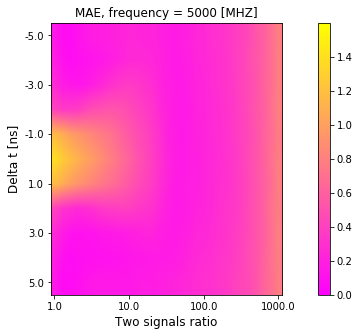

100%|██████████| 11/11 [02:39<00:00, 14.47s/it]


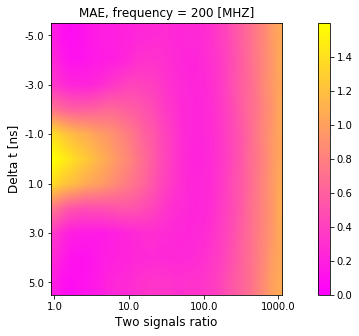

100%|██████████| 11/11 [02:46<00:00, 15.13s/it]


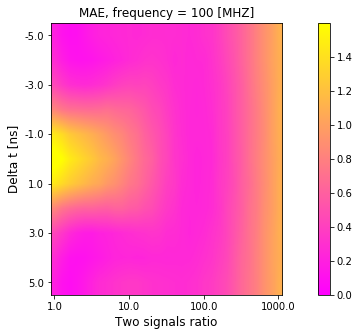

100%|██████████| 11/11 [02:33<00:00, 13.97s/it]


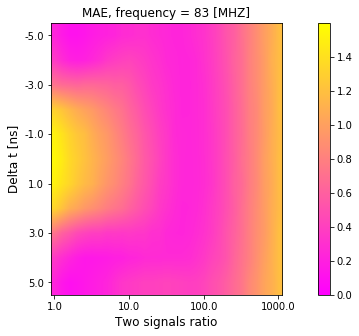

100%|██████████| 11/11 [02:28<00:00, 13.49s/it]


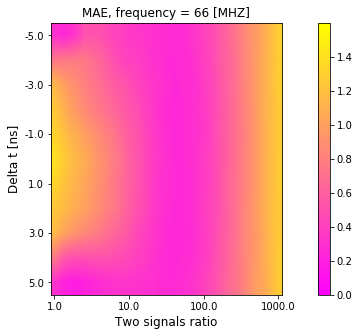

100%|██████████| 11/11 [02:17<00:00, 12.51s/it]


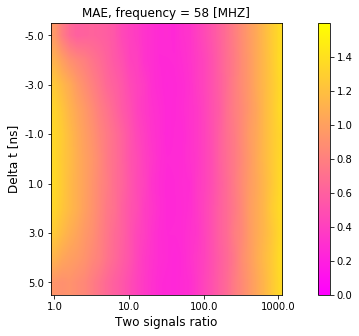

100%|██████████| 11/11 [02:33<00:00, 13.95s/it]


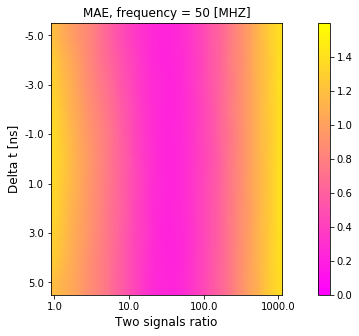

In [30]:
for freq in freq_values:
    X_origin, y_origin = get_data()
    scores_dict = calculate_scores(X_origin, alpha_values, tau_values, data_size=1000, freq=freq)
    plot_color_map(scores_dict, alpha_values, tau_values, freq=freq)
    save_obj(scores_dict, 'scores_freq=' + str(freq))
#     plot_score_3d(scores_dict)

### -----------------

In [90]:
model = get_models()[0]
X_origin, y_origin = get_data()
X, y = prepare_data(X_origin, tau_range, alpha_range, data_size=len(X_origin), to_print=True)
model.fit(X, y)

X shape: (7848, 1024)
y shape: (7848,)


HuberRegressor(alpha=0.00759, epsilon=4.927, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

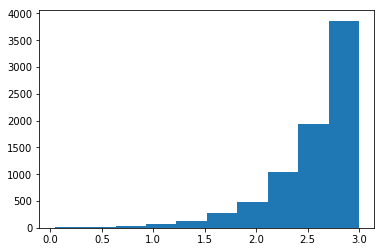

In [91]:
plt.hist(y)
plt.show()

In [92]:
from sklearn.utils import shuffle

def prepare_data(X_origin, tau_range, alpha_range, data_size=1000, to_print=False):    
    X = []
    y = []
    alpha_values = []
    tau_values = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        signal = generate_multi_signal(X_origin, tau, alpha)['multi']
        
        X.append(signal)
        y.append(np.log10(alpha))
        
        alpha_values.append(alpha)
        tau_values.append(tau)
   
    X = np.array(X)
    y = np.array(y)
    
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

#     plt.scatter(alpha_values, tau_values)
#     plt.show()
    
    return X, y

(array([  10.,   15.,   32.,   64.,  132.,  284.,  477., 1034., 1936.,
        3864.]),
 array([0.04139269, 0.33724473, 0.63309677, 0.92894882, 1.22480086,
        1.52065291, 1.81650495, 2.112357  , 2.40820904, 2.70406109,
        2.99991313]),
 <a list of 10 Patch objects>)

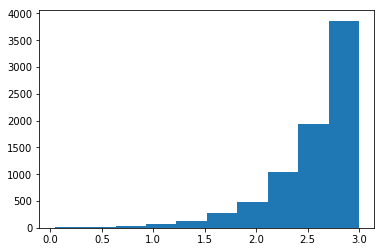

In [93]:
plt.hist(y)

In [94]:
X_cur, y_cur = prepare_data(X_origin, [100], [0.5], data_size=100)
y_pred = model.predict(X_cur)

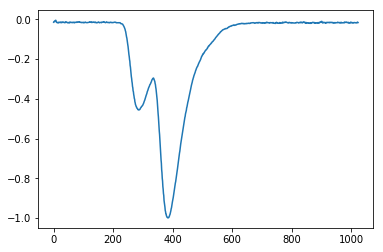

In [95]:
plt.plot(X_cur[0])

(array([ 2.,  0.,  2., 24., 25., 16., 12.,  8.,  7.,  4.]),
 array([-2.24721969, -2.15186683, -2.05651397, -1.96116112, -1.86580826,
        -1.7704554 , -1.67510255, -1.57974969, -1.48439683, -1.38904398,
        -1.29369112]),
 <a list of 10 Patch objects>)

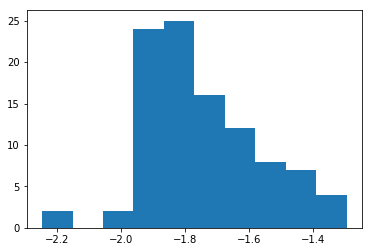

In [96]:
plt.hist(y_pred)

In [97]:
mean_absolute_error(y_pred, y_cur)

1.4439394322604215

In [98]:
y_cur

array([-0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30103,
       -0.30103, -0.30103, -0.30103, -0.30103, -0.30103, -0.30

(array([999., 999., 999., 999., 999., 999., 999., 999., 999., 999.]),
 array([  1.  , 100.89, 200.78, 300.67, 400.56, 500.45, 600.34, 700.23,
        800.12, 900.01, 999.9 ]),
 <a list of 10 Patch objects>)

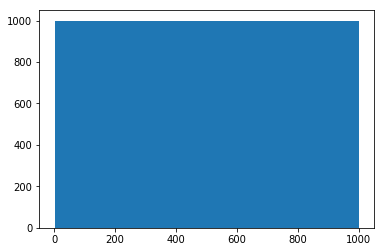

In [51]:
plt.hist(alpha_range)

In [53]:
y_pred

array([13.85775726, 13.92258476, 14.00500662, 13.67247997, 25.96626253,
       13.92857851, 14.04120496, 28.05713726, 13.88992435, 14.12354251,
       13.88323996, 27.12885427, 27.24101515, 27.43791504, 13.74742249,
       14.02761666, 13.82056656, 13.74172561, 13.74442902, 27.05214419,
       13.86223256, 27.46125246, 27.0117973 , 27.05705694, 27.32949661,
       27.35048799, 13.65172367, 27.37129612, 13.9200668 , 26.18991183,
       14.00368087, 13.86474566, 13.93566013, 26.76513289, 13.95751973,
       13.50592748, 27.5722483 , 13.74575206, 13.82487285, 13.75590709,
       28.03533435, 13.96536155, 26.65804753, 13.6118604 , 27.79691818,
       27.42385   , 13.97260675, 14.13618965, 27.13943151, 13.80780258,
       27.80158985, 27.48773553, 13.79087424, 27.09915082, 25.81363566,
       26.79835554, 27.37084277, 27.57607683, 13.83576789, 27.64780163,
       13.7711013 , 26.88124381, 25.61807987, 13.82220114, 13.6675616 ,
       26.41573159, 25.81530534, 14.01696329, 13.84164775, 26.82

In [71]:
y_pred

array([13.85775726, 13.92258476, 14.00500662, 13.67247997, 25.96626253,
       13.92857851, 14.04120496, 28.05713726, 13.88992435, 14.12354251,
       13.88323996, 27.12885427, 27.24101515, 27.43791504, 13.74742249,
       14.02761666, 13.82056656, 13.74172561, 13.74442902, 27.05214419,
       13.86223256, 27.46125246, 27.0117973 , 27.05705694, 27.32949661,
       27.35048799, 13.65172367, 27.37129612, 13.9200668 , 26.18991183,
       14.00368087, 13.86474566, 13.93566013, 26.76513289, 13.95751973,
       13.50592748, 27.5722483 , 13.74575206, 13.82487285, 13.75590709,
       28.03533435, 13.96536155, 26.65804753, 13.6118604 , 27.79691818,
       27.42385   , 13.97260675, 14.13618965, 27.13943151, 13.80780258,
       27.80158985, 27.48773553, 13.79087424, 27.09915082, 25.81363566,
       26.79835554, 27.37084277, 27.57607683, 13.83576789, 27.64780163,
       13.7711013 , 26.88124381, 25.61807987, 13.82220114, 13.6675616 ,
       26.41573159, 25.81530534, 14.01696329, 13.84164775, 26.82

In [42]:
model = StackingRegressor(regressors=models, meta_regressor=models[0])
model.fit(X, y)

KeyboardInterrupt: 

In [22]:
alpha_scores = []
alpha_test_range = np.arange(1, 1002, 1)

In [23]:
for alpha in alpha_test_range:
    X_cur, y_cur = prepare_data(X_origin, tau_range, [alpha], data_size=1000, to_print=False)
    y_pred = model.predict(X_cur)
    alpha_scores.append(mean_absolute_error(y_pred, y_cur))

In [29]:
np.exp(1)**0.1

1.1051709180756477

In [31]:
alpha_scores[300]

0.08166809121229691

In [28]:
alpha_scores[700]

0.1032046420005781

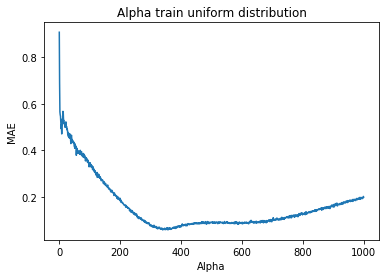

In [32]:
plt.title("Alpha train uniform distribution")
plt.ylabel("MAE")
plt.xlabel("Alpha")
plt.plot(alpha_scores)
plt.show()

In [ ]:
####